In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
plt.style.use('ggplot')

# Yellow cabs

## Initial data processing

In [14]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

def fill_with_missing_indicator(df, column_name, fill_value):
    '''
    Function to fill missing rows with certain value and creates informative column
    '''
    new_column = {f'{column_name}_MI': lambda x: np.where(x[column_name].isna(), 1, 0)}
    df = df.assign(**new_column)
    df[column_name] = df[column_name].fillna(fill_value) # which value to indicate missingnes
    return df

## missing value imputation with values out of range of standard values, adding binary missing indicator
df = (df
    .pipe(fill_with_missing_indicator, column_name='passenger_count', fill_value=-1)
    .pipe(fill_with_missing_indicator, column_name='RatecodeID', fill_value=0)
    .pipe(fill_with_missing_indicator, column_name='store_and_fwd_flag', fill_value='Missing')
    .pipe(fill_with_missing_indicator, column_name='congestion_surcharge', fill_value=-1)
    .pipe(fill_with_missing_indicator, column_name='airport_fee', fill_value=-1)
    ## also adding simple information about traveling time in minutes
    .assign(trip_time_min=lambda x: (x['tpep_dropoff_datetime']-x['tpep_pickup_datetime'])/timedelta(minutes=1))
)
## removing columns with problematic date, cases where pickup happend after dropoff
df = df.drop(index=df[(df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'])].index)
## filtering data to find "valid trip cases", explained below
df = (
    df[
        # trip where the total amount wasnt negative
        (df['total_amount'] >= 0)
        & (
            ## trips with 0 traveling, most likely canceled
            ((df['tpep_dropoff_datetime'] >= df['tpep_pickup_datetime']) & (df['trip_distance'] == 0) & (df['PULocationID'] == df['DOLocationID']))
            ## trips between districts, ie they took some time to travel, distance and start end areas changes
            | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] != df['DOLocationID']))
            ## there may also be trips within a district so lets keep them as long as there is some kind of traveling involved
            | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] == df['DOLocationID']))
        )
    ]
)

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,passenger_count_MI,RatecodeID_MI,store_and_fwd_flag_MI,congestion_surcharge_MI,airport_fee_MI,trip_time_min
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.0,14.30,2.5,0.00,0,0,0,0,0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.0,16.90,2.5,0.00,0,0,0,0,0,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.0,34.90,2.5,0.00,0,0,0,0,0,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,1.0,20.85,0.0,1.25,0,0,0,0,0,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.0,19.68,2.5,0.00,0,0,0,0,0,10.833333


## Exploration

### Time vs distance

I know that there is stil alot of problematic data entries, there is definetly a problem with a distance and time spent traveling since there are trips that took more than hours with low pay and low distance. There are some cases with very high distance in short time, but I guess these can be possible if there are at the edges of New York?

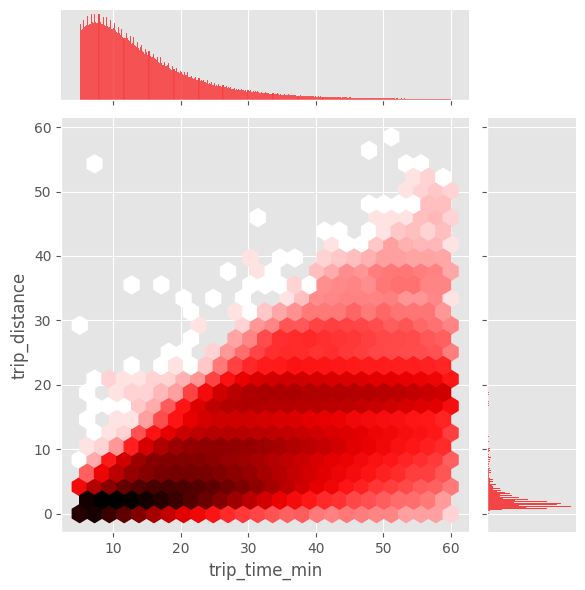

In [15]:
df_avgrides = df[
    (df['trip_time_min'] <= 60) 
    & (df['trip_time_min'] >= 5) 
    & (df['trip_distance'] <= 100)
]
sns.jointplot(df_avgrides, y='trip_distance', x='trip_time_min', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25), )#marginal_kws=dict(kde=True))

### time trip vs cost

So this one is definetly interesting, time trip vs cost. There are some clear outlier, with insane costs, I actually wonder if these are some kind of penalties rather than wrongly entered data.

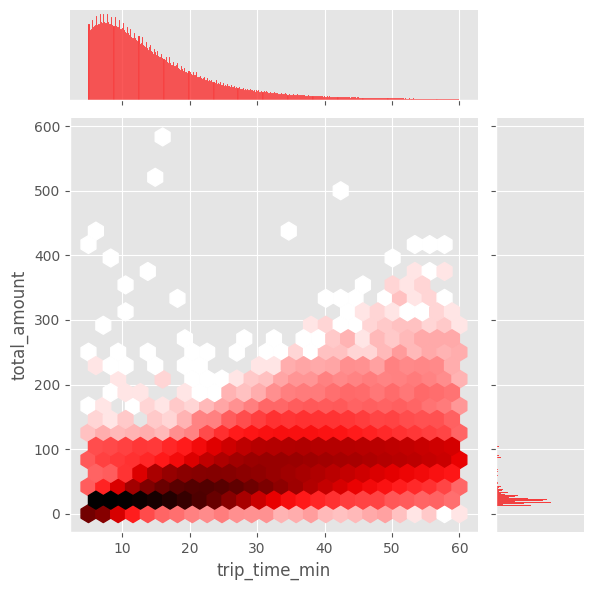

In [16]:
sns.jointplot(df_avgrides, x='trip_time_min', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25), )#marginal_kws=dict(kde=True))

### trip distance vs total amount

So even more outliers, short trips with high costs, and long trips with near zero cost.

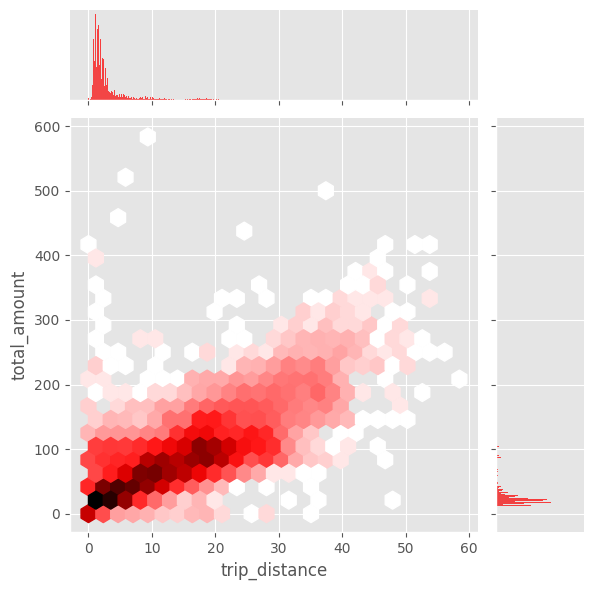

In [17]:
sns.jointplot(df_avgrides, x='trip_distance', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

## Where are people traveling from to where

Map district to area, get some informations about number of trips, cost, travels, how many trips from each area to other area

# Conclusions

- What are the key factors contribution to the price of a trip
- I should also take a closer look the outliers found in amount vs distance, mayby they are oriented with some kind of late drives where drunk people broke something in a cab?


In [11]:
df_avgrides[df_avgrides['total_amount'] <0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,passenger_count_MI,RatecodeID_MI,store_and_fwd_flag_MI,congestion_surcharge_MI,airport_fee_MI,trip_time_min
263,2,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,1.0,N,142,50,4,...,-1.0,-14.30,-2.5,0.0,0,0,0,0,0,7.633333
324,2,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,1.0,N,238,167,4,...,-1.0,-30.40,-2.5,0.0,0,0,0,0,0,21.683333
923,2,2023-01-01 00:34:39,2023-01-01 00:40:25,2.0,0.85,1.0,N,79,113,4,...,-1.0,-12.20,-2.5,0.0,0,0,0,0,0,5.766667
1303,2,2023-01-01 00:02:59,2023-01-01 00:08:01,2.0,0.68,1.0,N,234,164,4,...,-1.0,-12.20,-2.5,0.0,0,0,0,0,0,5.033333
1352,2,2023-01-01 00:40:02,2023-01-01 01:07:56,1.0,9.90,1.0,N,90,67,4,...,-1.0,-55.15,-2.5,0.0,0,0,0,0,0,27.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053677,2,2023-01-26 09:14:39,2023-01-26 10:00:37,-1.0,4.81,0.0,Missing,181,113,0,...,1.0,-46.98,-1.0,-1.0,1,1,1,1,1,45.966667
3056078,2,2023-01-27 08:20:00,2023-01-27 08:44:00,-1.0,2.50,0.0,Missing,125,107,0,...,1.0,-21.80,-1.0,-1.0,1,1,1,1,1,24.000000
3056825,2,2023-01-27 15:28:00,2023-01-27 15:55:00,-1.0,4.81,0.0,Missing,143,116,0,...,1.0,-50.85,-1.0,-1.0,1,1,1,1,1,27.000000
3062459,2,2023-01-29 20:35:00,2023-01-29 20:42:00,-1.0,0.06,0.0,Missing,48,48,0,...,1.0,-44.32,-1.0,-1.0,1,1,1,1,1,7.000000


# Green taxis

In [4]:
# df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')